In [1]:
import os
import shutil
import random

# Set the path to the root folder containing the class folders
root_folder = r'\datasets\belgium\BelgiumTSC_selectedall'

# Set the percentage of images to use for testing
test_ratio = 0.2

# Create the train and test folders
train_folder = os.path.join(root_folder, 'train_2')
test_folder = os.path.join(root_folder, 'test_2')
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Iterate over each class folder in the root folder
for class_folder_name in os.listdir(root_folder):
    class_folder_path = os.path.join(root_folder, class_folder_name)
    if not os.path.isdir(class_folder_path):
        continue

    # Create the train and test folders for this class
    class_train_folder = os.path.join(train_folder, class_folder_name)
    class_test_folder = os.path.join(test_folder, class_folder_name)
    os.makedirs(class_train_folder, exist_ok=True)
    os.makedirs(class_test_folder, exist_ok=True)

    # Iterate over each image file in the class folder
    for filename in os.listdir(class_folder_path):
        if not filename.endswith('.ppm'):
            continue

        # Determine whether this image should be used for testing or training
        if random.random() < test_ratio:
            # Copy the image to the test folder for this class
            src_path = os.path.join(class_folder_path, filename)
            dst_path = os.path.join(class_test_folder, filename)
            shutil.copyfile(src_path, dst_path)
        else:
            # Copy the image to the train folder for this class
            src_path = os.path.join(class_folder_path, filename)
            dst_path = os.path.join(class_train_folder, filename)
            shutil.copyfile(src_path, dst_path)

In [3]:
from PIL import Image
import os

# Set the path to the directory containing the folders of PPM images
input_dir = r'\datasets\belgium\test'

# Set the path to the directory where the PNG images will be saved
output_dir = r'\datasets\belgium\test_part'
os.makedirs(output_dir, exist_ok=True)

# Iterate over each subdirectory in the input directory
for subdirectory in os.listdir(input_dir):
    subdirectory_path = os.path.join(input_dir, subdirectory)

    # Skip files and non-directories
    if not os.path.isdir(subdirectory_path):
        continue

    # Create the corresponding output subdirectory
    output_subdirectory = os.path.join(output_dir, subdirectory)
    os.makedirs(output_subdirectory, exist_ok=True)

    # Iterate over each PPM image in the subdirectory
    for filename in os.listdir(subdirectory_path):
        if not filename.endswith('.ppm'):
            continue

        # Load the PPM image
        ppm_path = os.path.join(subdirectory_path, filename)
        with Image.open(ppm_path) as im:
            # Convert the image to PNG format
            png_path = os.path.join(output_subdirectory, os.path.splitext(filename)[0] + '.png')
            im.save(png_path, format='PNG')

In [3]:
# Filtering the number of images
import os

root_folder = r'\datasets\belgium\test_164"

for foldername, subfolders, filenames in os.walk(root_folder):
    num_images = len(filenames)
    if num_images > 4:
        for filename in filenames[4:]:
            os.remove(os.path.join(foldername, filename))

## Setup and run transfer learning network (based on code of supervisor - PhD Artur Nowakowski)

In [6]:
# input dataset
#outFldSamplesTr =r'\datasets\belgium\train'
#outFldSamplesVal = r'\datasets\belgium\test'
outFldSamplesTr = r'\datasets\belgium\train_82'
outFldSamplesVal = r'\datasets\belgium\test_82'

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import tensorflow as tf

### Loading training and validation dataset

In [7]:
training_set = image_dataset_from_directory(outFldSamplesTr,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(224, 224))
validation_set = image_dataset_from_directory(outFldSamplesVal,
                                                  shuffle=True,
                                                  batch_size=32,
                                                  image_size=(224,224))

Found 240 files belonging to 30 classes.
Found 65 files belonging to 30 classes.


### Preparing a transfer learning network

In [11]:
import sys
!{sys.executable} -m pip install h5py

In [4]:
# 1. Importing first layers from existing pre-trained network called VGG-16

import h5py

## Loading VGG16 model
#base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
#base_model.summary()

## Loading VGG16 model
#full_model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
#full_model.summary()

# Loading MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

# Freeze four convolution blocks
#for layer in vgg_model.layers[:15]:
#    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [5]:
# 2. Adding new classification layers for number of classes that is needed (2 in this case)

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(1024, activation='relu')
dense_layer_2 = layers.Dense(30, activation='relu')
prediction_layer = layers.Dense(30, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)
    
model.summary()



0 mobilenet_1.00_224 True
1 flatten True
2 dense True
3 dense_1 True
4 dense_2 True
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dense_1 (Dense)             (None, 30)                30750     
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
Total params: 54,641,792
Trainable par

# Fine-tuning the network

In [18]:
import winsound
#lr = 0.003
#lr = 0.0003
lr = 0.00003
#opt = SGD(learning_rate=lr)
opt = Adam(learning_rate=lr)
#opt = RMSprop(learning_rate=lr)


model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    #loss='kl_divergence',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='accuracy', mode='max', patience=5,  restore_best_weights=True)

model.fit(training_set, epochs=10, batch_size=100, callbacks=[es], validation_data=validation_set)

# play a sound notification when the code is finished running
frequency = 2500  # set frequency (in Hz)
duration = 1000  # set duration (in ms)
winsound.Beep(frequency, duration)


Epoch 1/10
72/72 [==============================] - 910s 13s/step - loss: 1.7045 - accuracy: 0.6382 - val_loss: 0.2672 - val_accuracy: 0.9483
Epoch 2/10
72/72 [==============================] - 896s 12s/step - loss: 0.0535 - accuracy: 0.9877 - val_loss: 0.1487 - val_accuracy: 0.9875
Epoch 3/10
72/72 [==============================] - 877s 12s/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.1639 - val_accuracy: 0.9875
Epoch 4/10
72/72 [==============================] - 890s 12s/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.1730 - val_accuracy: 0.9875
Epoch 5/10
72/72 [==============================] - 871s 12s/step - loss: 3.9249e-04 - accuracy: 1.0000 - val_loss: 0.1786 - val_accuracy: 0.9875
Epoch 6/10
72/72 [==============================] - 872s 12s/step - loss: 2.4630e-04 - accuracy: 1.0000 - val_loss: 0.1829 - val_accuracy: 0.9875
Epoch 7/10
72/72 [==============================] - 885s 12s/step - loss: 1.7368e-04 - accuracy: 1.0000 - val_loss: 0.1873 - val_accuracy: 0

In [19]:
directory = r'\results\all\VGG16\SCC_Adam\\'

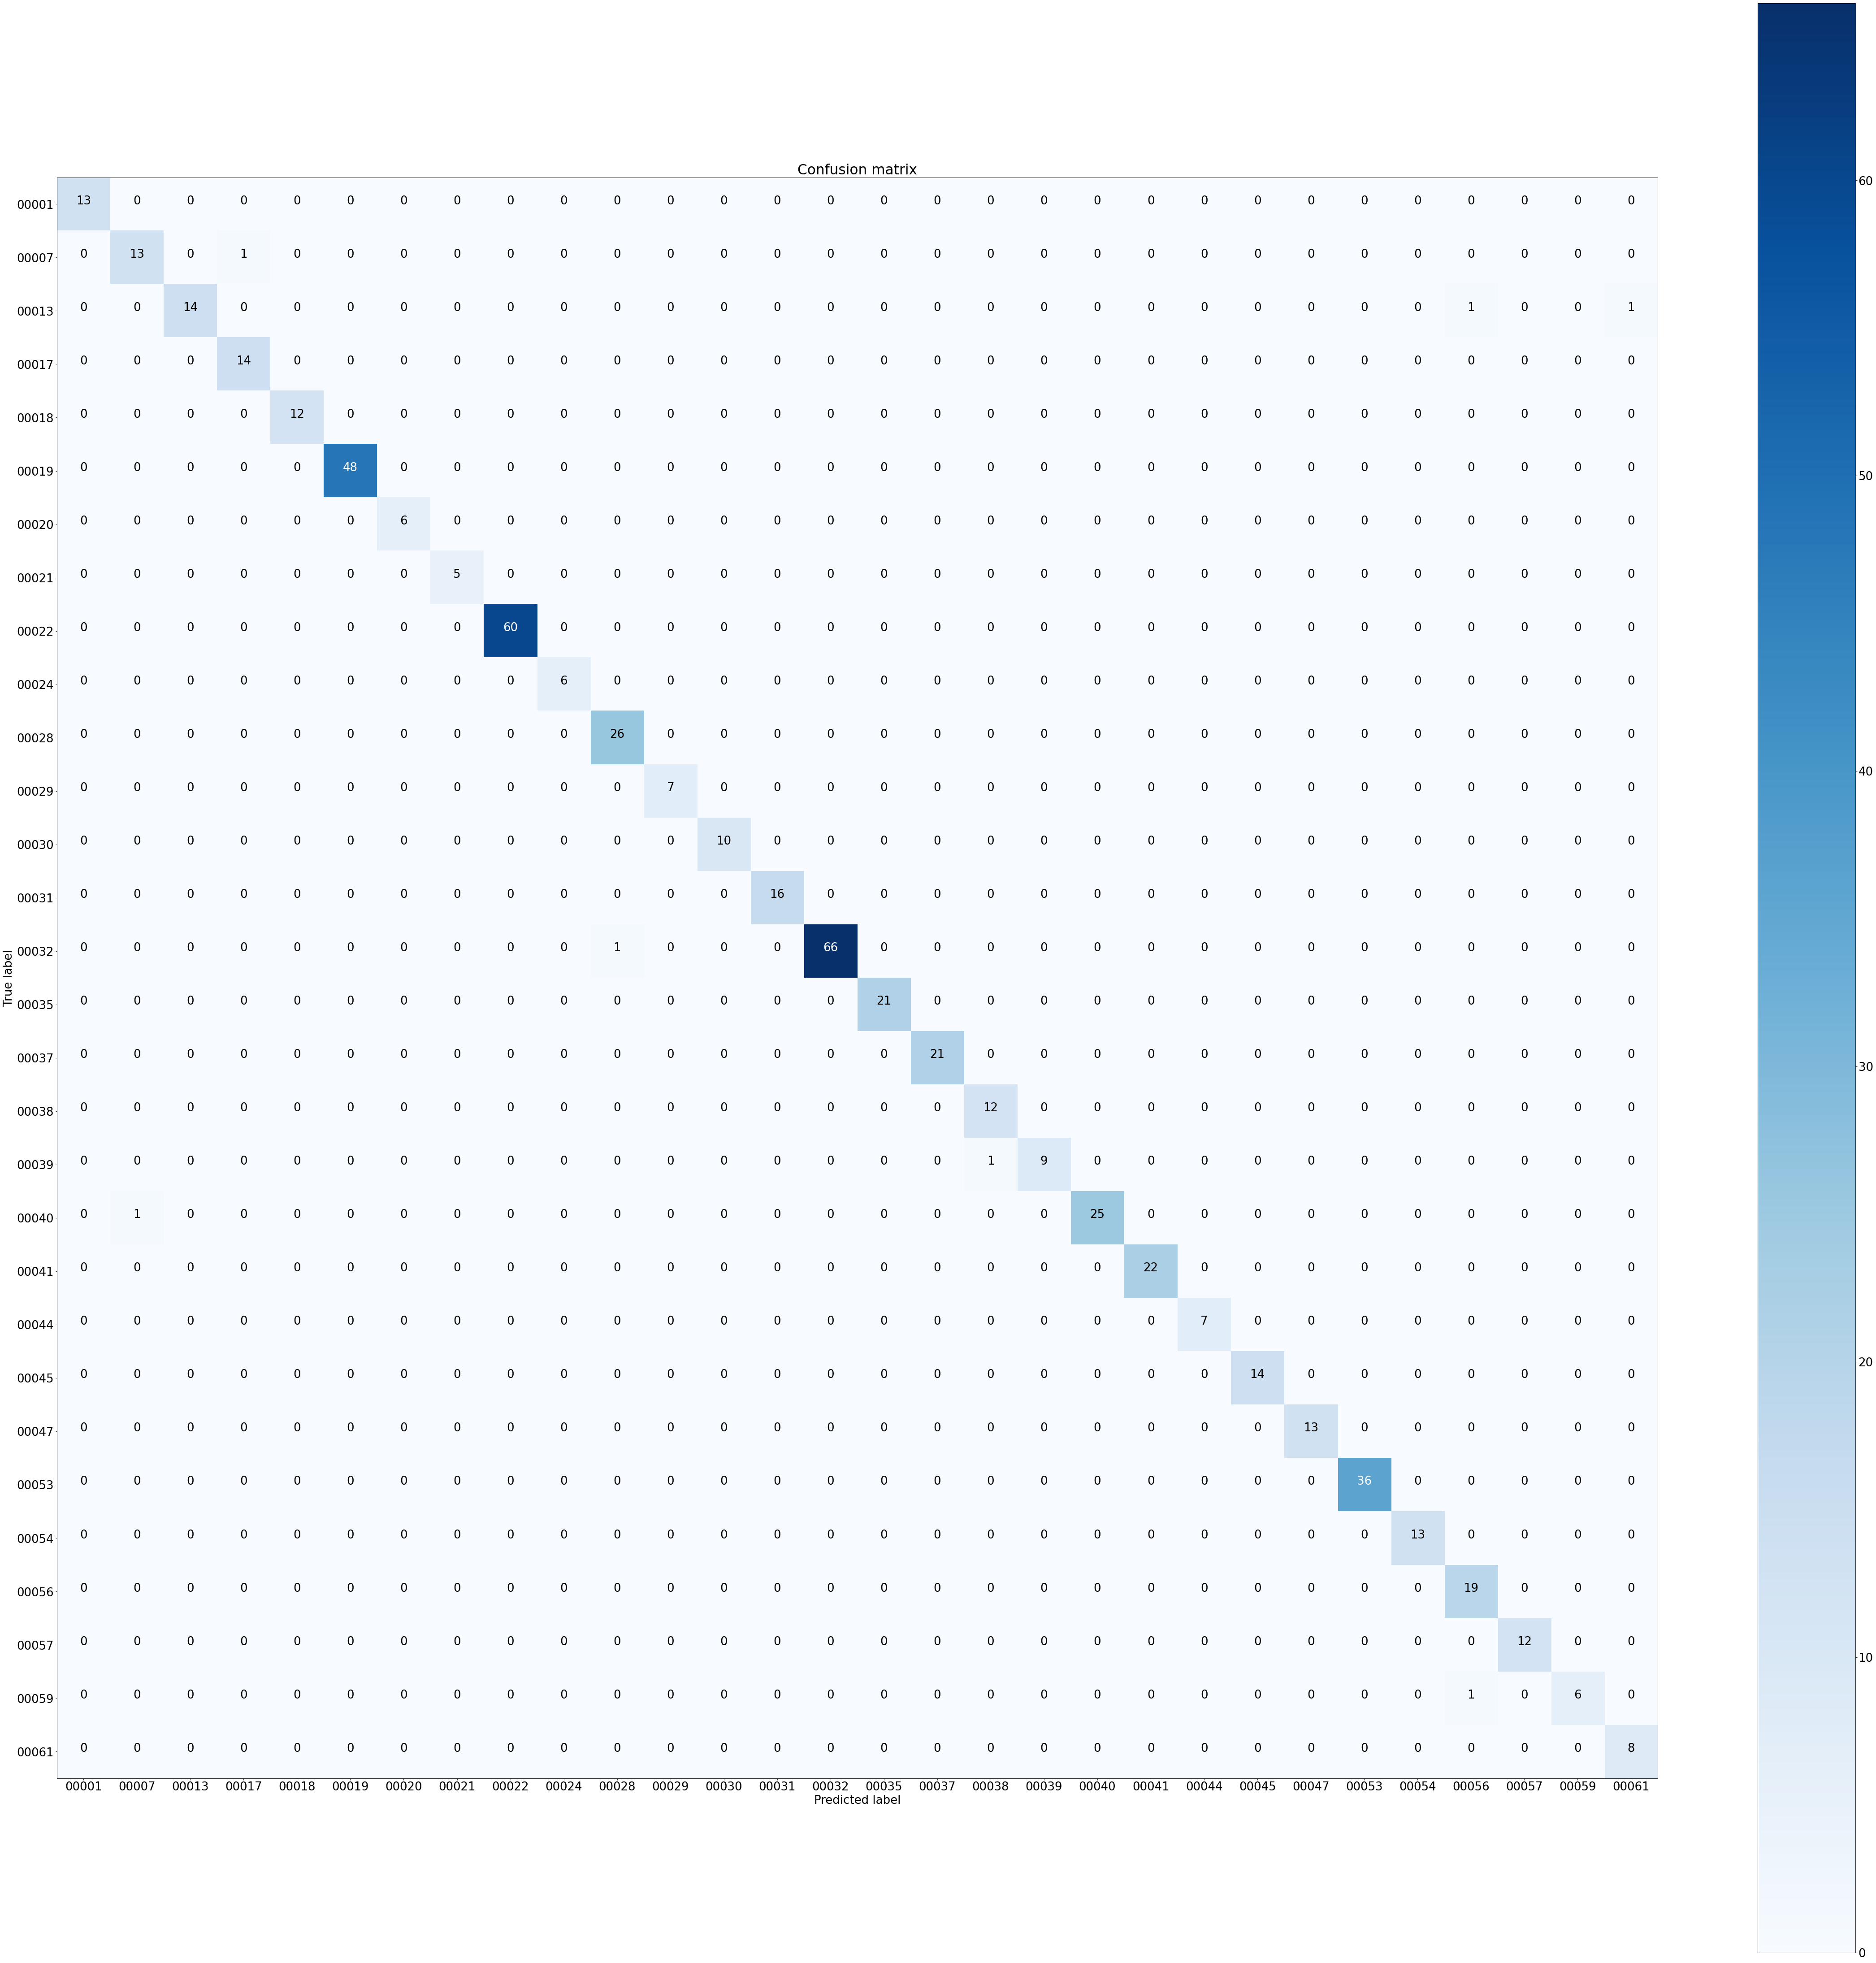

In [20]:
#dziwne wartości ale ok

import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Get true labels and predicted labels for the validation set
val_labels = []
val_preds = []
for x, y in validation_set:
    val_labels.extend(y.numpy())
    val_preds.extend(np.argmax(model.predict(x), axis=-1))

# Compute confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Save confusion matrix as CSV file
filename = 'cm_{:.6f}.csv'.format(lr)
np.savetxt(os.path.join(directory, filename), cm, delimiter=',')
# Define class names and plot the confusion matrix
class_names = ['00001', '00007', '00013', '00017', '00018', '00019',
              '00020', '00021', '00022', '00024', '00028', '00029',
              '00030','00031','00032','00035', '00037', '00038',
              '00039', '00040', '00041', '00044', '00045', '00047',
              '00053', '00054', '00056', '00057', '00059','00061'] 
plt.figure(figsize=(80,80))
plt.rcParams.update({'font.size': 26})
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.xticks(ticks=[0, 1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 ,21, 22, 23, 24, 25, 26, 27, 28, 29], labels=class_names) #tu rozszerzyć
plt.yticks(ticks=[0, 1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 ,21, 22, 23, 24, 25, 26, 27, 28, 29], labels=class_names) #tu rozszerzyć
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()

# Add values to the confusion matrix plot
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f'{cm[i, j]}', horizontalalignment="center", 
             color="white" if cm[i, j] > thresh else "black")
plt.show()

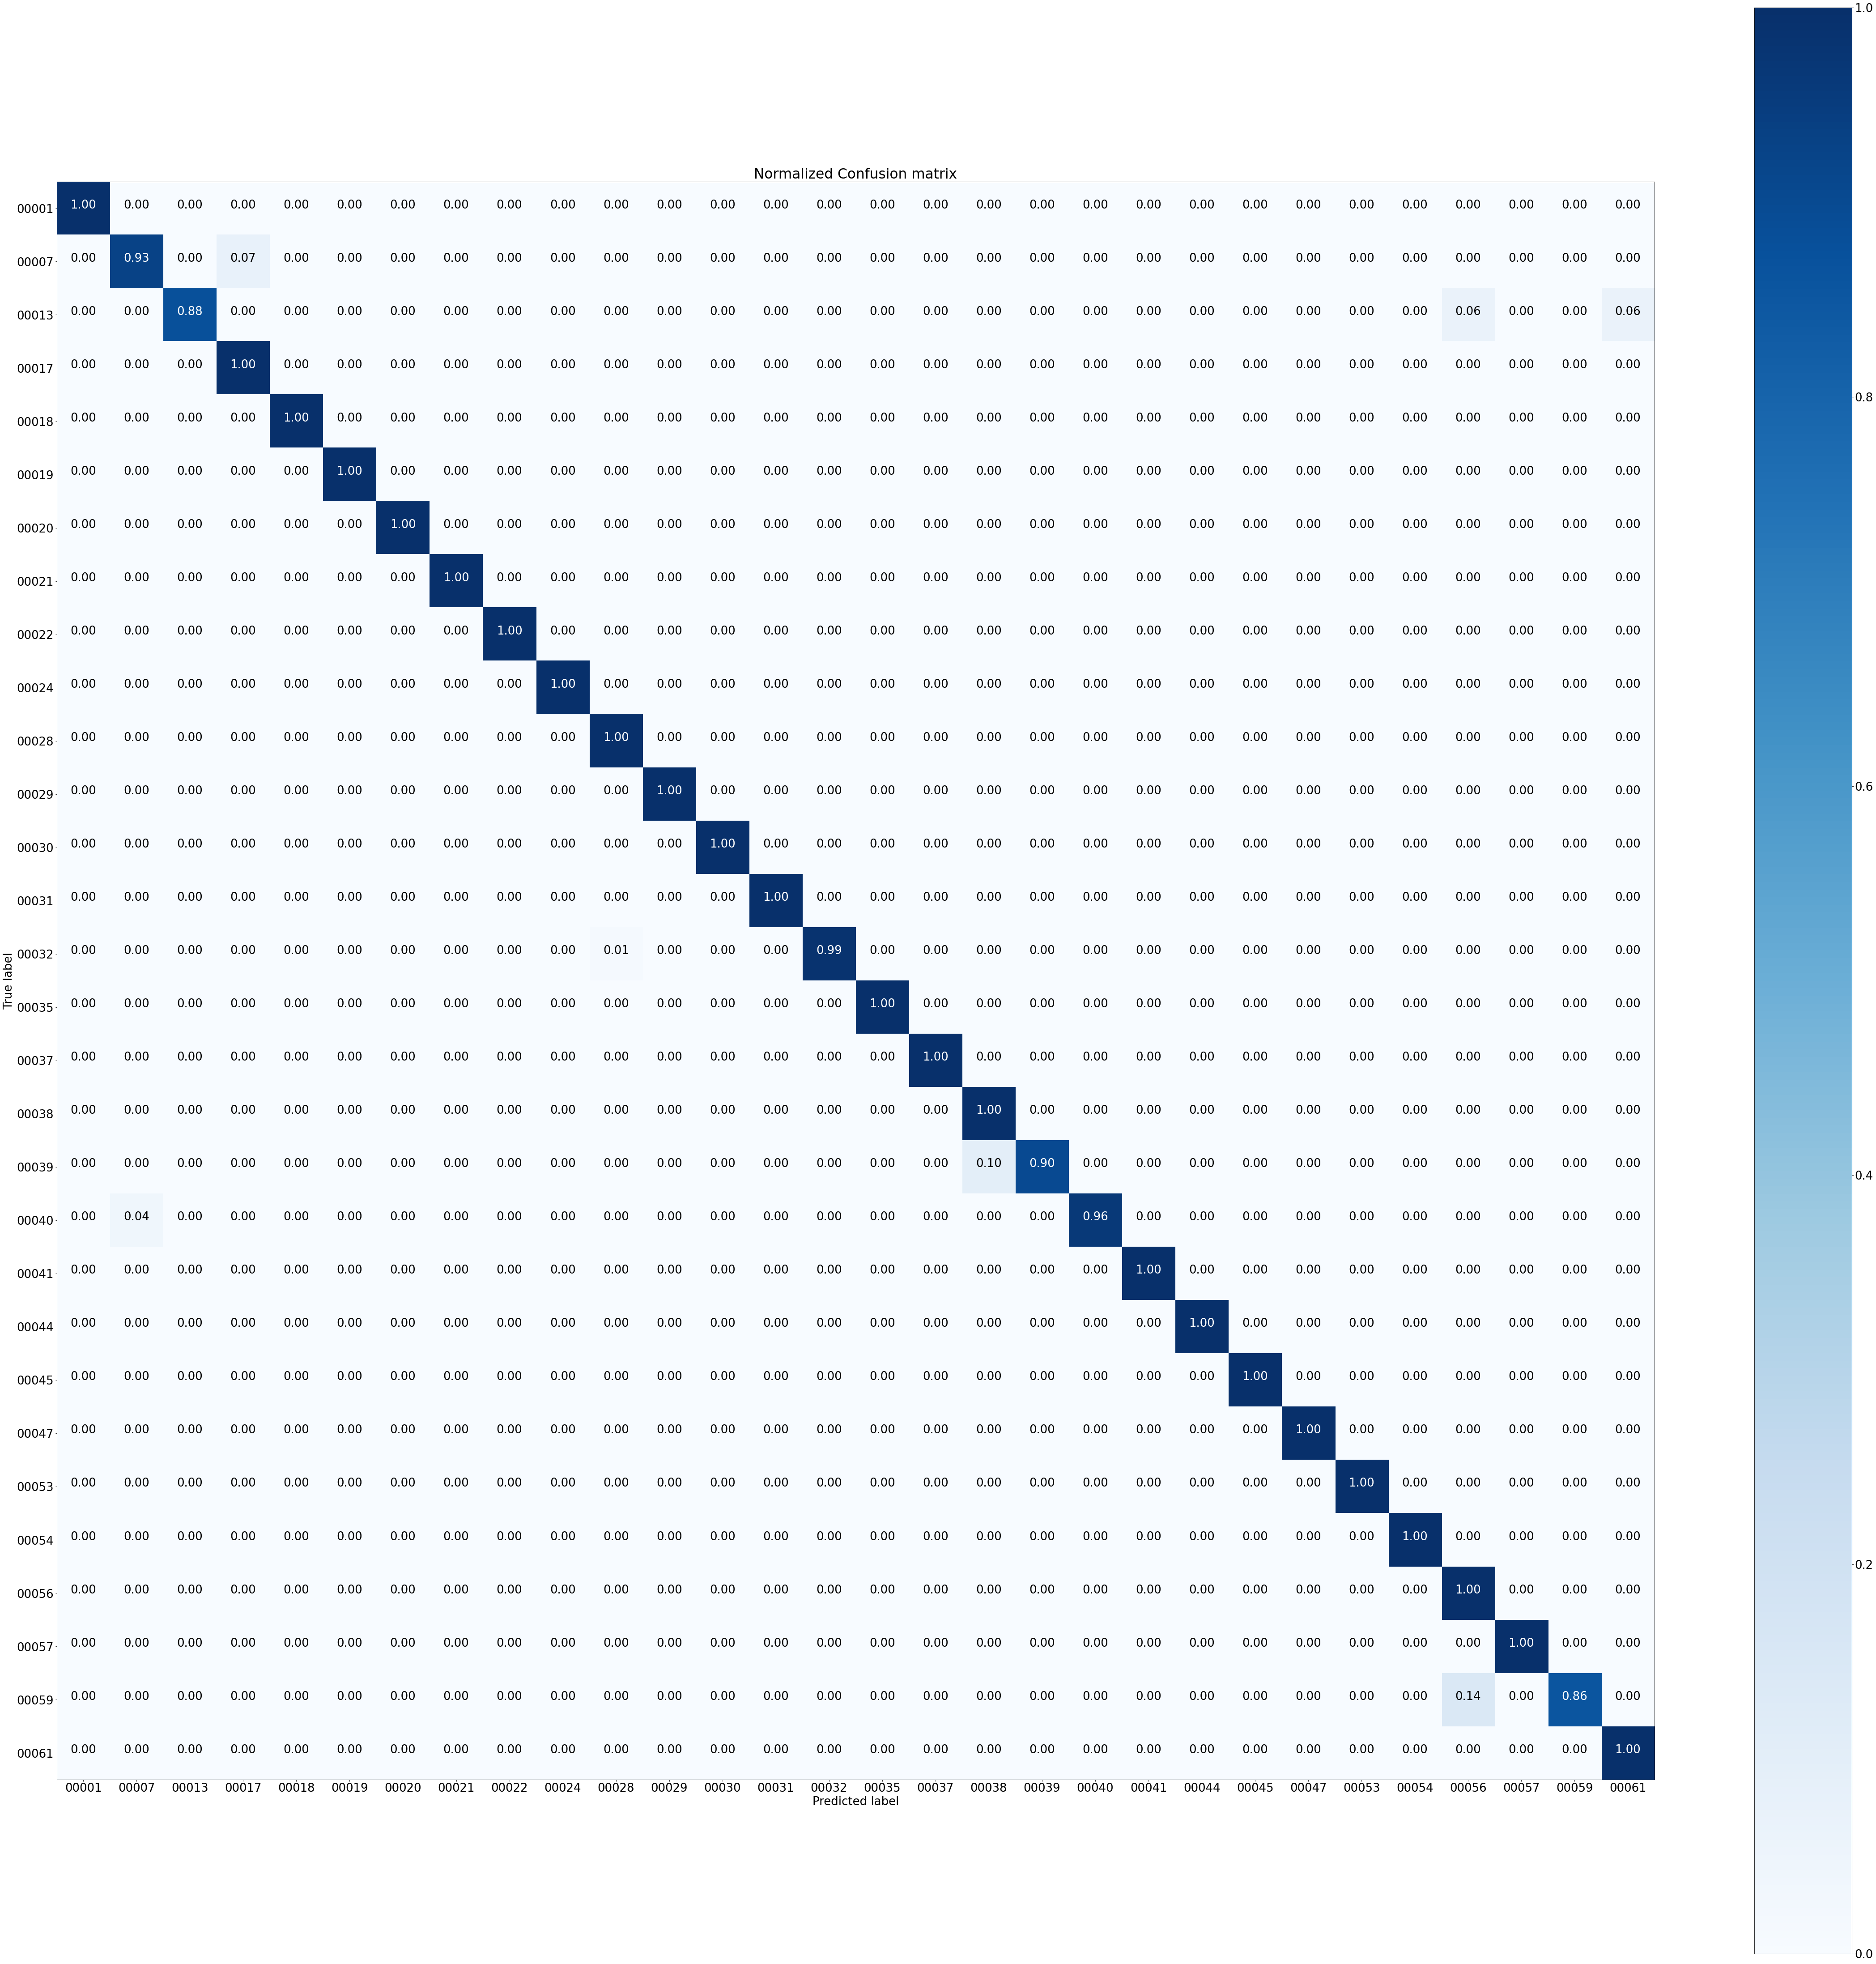

In [21]:
#normalized confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Get true labels and predicted labels for the validation set
val_labels = []
val_preds = []
for x, y in validation_set:
    val_labels.extend(y.numpy())
    val_preds.extend(np.argmax(model.predict(x), axis=-1))

# Compute confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Normalize confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Save confusion matrix as CSV file
filename = 'cm_n_{:.6f}.csv'.format(lr)
np.savetxt(os.path.join(directory, filename), cm_norm, delimiter=',')

# Define class names and plot the confusion matrix
class_names = ['00001', '00007', '00013', '00017', '00018', '00019',
              '00020', '00021', '00022', '00024', '00028', '00029',
              '00030','00031','00032','00035', '00037', '00038',
              '00039', '00040', '00041', '00044', '00045', '00047',
              '00053', '00054', '00056', '00057', '00059','00061']
plt.figure(figsize=(80,80))
plt.rcParams.update({'font.size': 26})
plt.imshow(cm_norm, cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix')
plt.xticks(ticks=[0, 1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 ,21, 22, 23, 24, 25, 26, 27, 28, 29], labels=class_names) #tu rozszerzyć
plt.yticks(ticks=[0, 1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 ,21, 22, 23, 24, 25, 26, 27, 28, 29], labels=class_names) #tu rozszerzyć
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()

# Add values to the confusion matrix plot
thresh = cm_norm.max() / 2
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    plt.text(j, i, f'{cm_norm[i, j]:.2f}', horizontalalignment="center", 
             color="white" if cm_norm[i, j] > thresh else "black")
plt.show()

In [22]:

import winsound

# folder for storing models
model_dir = os.path.join(directory, 'model_{:.6f}'.format(lr))
model.save(model_dir)


# play a sound notification when the code is finished running
frequency = 2500  # set frequency (in Hz)
duration = 1000  # set duration (in ms)
winsound.Beep(frequency, duration)

INFO:tensorflow:Assets written to: D:\MMNS\mgr\wyniki\all\VGG16\SCC_Adam\\model_0.000030\assets


### Loading model

In [38]:
# folder for storing models
outFldModels = r'\datasets\belgium\models\82\SCC_RMS'
model = models.load_model(outFldModels+'\\model00003')

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
 dense_2 (Dense)             (None, 2)                 6         
                                                                 
Total params: 40,407,880
Trainable params: 40,407,880
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 224, 224, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'vgg16_input'}},
  {'class_name': 'Functional',
   'config': {'name': 'vgg16',
    'layers': [{'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 224, 224, 3),
       'dtype': 'float32',
       'sparse': False,
       'ragged': False,
       'name': 'input_2'},
      'name': 'input_2',
      'inbound_nodes': []},
     {'class_name': 'Conv2D',
      'config': {'name': 'block1_conv1',
       'trainable': True,
       'dtype': 'float32',
       'filters': 64,
       'kernel_size': (3, 3),
       'strides': (1, 1),
       'padding': 'same',
       'data_format': 'channels_last',
       'dilation_rate': (1, 1),
       'groups': 1,
       'activation': 'relu',
       'use_bias': True,
       'kernel_initializer': {'class_name': 'GlorotUniform',
        'config': {'seed': None

In [1]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cm = confusion_matrix(validation_set, val_accuracy)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.set_xticks(range(len(train_generator.class_indices)))
ax.set_xticklabels(train_generator.class_indices.keys(), fontsize=10)
ax.set_yticks(range(len(train_generator.class_indices)))
ax.set_yticklabels(train_generator.class_indices.keys(), fontsize=10)
for i in range(len(train_generator.class_indices)):
    for j in range(len(train_generator.class_indices)):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=16)
plt.show()

NameError: name 'validation_set' is not defined

In [52]:



import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Wczytaj macierz pomyłek z pliku CSV
confusion_matrix_df = pd.read_csv(r'D:\MMNS\mgr\wyniki\82\MobileNet\SCC_SGD\cm_0.000030.csv', header=None)
confusion_matrix = np.array(confusion_matrix_df.values)

# Oblicz precyzję, czułość i f1 score dla każdej klasy
precision = []
recall = []
f1 = []

for i in range(len(confusion_matrix)):
    tp = confusion_matrix[i,i]
    fp = np.sum(confusion_matrix[:,i]) - tp
    fn = np.sum(confusion_matrix[i,:]) - tp
    
    precision_i = tp / (tp + fp)
    recall_i = tp / (tp + fn)
    f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)
    
    precision.append(precision_i)
    recall.append(recall_i)
    f1.append(f1_i)

# Oblicz ważony średnią precyzję, czułość i f1 score dla wszystkich klas
weighted_precision = np.sum(np.array(precision) * np.sum(confusion_matrix, axis=1)) / np.sum(confusion_matrix)
weighted_recall = np.sum(np.array(recall) * np.sum(confusion_matrix, axis=1)) / np.sum(confusion_matrix)
weighted_f1 = np.sum(np.array(f1) * np.sum(confusion_matrix, axis=1)) / np.sum(confusion_matrix)

print("Weighted precision: {}".format(weighted_precision))
print("Weighted recall: {}".format(weighted_recall))
print("Weighted F1 score: {}".format(weighted_f1))


Weighted precision: nan
Weighted recall: 0.4307692307692308
Weighted F1 score: nan


<ipython-input-52-dfdb72647fa2>:19: RuntimeWarning: invalid value encountered in double_scalars
  precision_i = tp / (tp + fp)
<ipython-input-52-dfdb72647fa2>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)


In [69]:
import numpy as np

# Load the normalized confusion matrix from the CSV file
confusion_matrix = np.genfromtxt(r"\results\82\MobileNet\SCC_SGD\cm_n_0.000030.csv", delimiter=',')
#confusion_matrix = np.genfromtxt(r"\results\82\MobileNet\SCC_SGD\cm_n_0.000300.csv", delimiter=',')
#confusion_matrix = np.genfromtxt(r"\results\82\MobileNet\SCC_SGD\cm_n_0.003000.csv", delimiter=',')

# Calculate the number of classes
num_classes = confusion_matrix.shape[0]

# Initialize arrays to store the precision, recall, and F1 score for each class
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1_score = np.zeros(num_classes)

# Calculate precision, recall, and F1 score for each class
for i in range(num_classes):
    true_positives = confusion_matrix[i, i]
    false_positives = np.sum(confusion_matrix[:, i]) - true_positives
    false_negatives = np.sum(confusion_matrix[i, :]) - true_positives
    
    precision[i] = true_positives / (true_positives + false_positives)
    recall[i] = true_positives / (true_positives + false_negatives)
    f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])

# Print the F1 score for each class
for i in range(num_classes):
    print(f'Class {i}: F1 score = {f1_score[i]}')


Class 0: F1 score = 0.6666666666666666
Class 1: F1 score = nan
Class 2: F1 score = 0.6666666666666666
Class 3: F1 score = nan
Class 4: F1 score = nan
Class 5: F1 score = 0.8
Class 6: F1 score = nan
Class 7: F1 score = 0.5
Class 8: F1 score = 0.5
Class 9: F1 score = nan
Class 10: F1 score = 0.5
Class 11: F1 score = 0.25
Class 12: F1 score = nan
Class 13: F1 score = 0.5
Class 14: F1 score = 0.5
Class 15: F1 score = nan
Class 16: F1 score = 0.6666666666666666
Class 17: F1 score = nan
Class 18: F1 score = 0.8
Class 19: F1 score = nan
Class 20: F1 score = 0.5714285714285715
Class 21: F1 score = 0.5
Class 22: F1 score = 0.6666666666666666
Class 23: F1 score = 0.28571428571428575
Class 24: F1 score = nan
Class 25: F1 score = 0.6829268292682926
Class 26: F1 score = 0.6666666666666666
Class 27: F1 score = 1.0
Class 28: F1 score = 0.6666666666666666
Class 29: F1 score = 1.0


<ipython-input-69-7df94464bc69>:22: RuntimeWarning: invalid value encountered in double_scalars
  precision[i] = true_positives / (true_positives + false_positives)
<ipython-input-69-7df94464bc69>:24: RuntimeWarning: invalid value encountered in double_scalars
  f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])


In [108]:
import numpy as np

# Load the normalized confusion matrix from the CSV file
confusion_matrix = np.genfromtxt(r"results\all\VGG16\SCC_SGD\cm_n_0.003000.csv", delimiter=',')
#confusion_matrix = np.genfromtxt(r"results\all\VGG16\SCC_SGD\cm_n_0.000300.csv", delimiter=',')
#confusion_matrix = np.genfromtxt(r"results\all\VGG16\SCC_SGD\cm_n_0.000030.csv", delimiter=',')

# Calculate the number of classes
num_classes = confusion_matrix.shape[0]

# Initialize arrays to store the precision, recall, and F1 score for each class
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1_score = np.zeros(num_classes)

# Calculate precision, recall, and F1 score for each class
for i in range(num_classes):
    true_positives = confusion_matrix[i, i]
    false_positives = np.sum(confusion_matrix[:, i]) - true_positives
    false_negatives = np.sum(confusion_matrix[i, :]) - true_positives
    
    # Handle division by zero
    if (true_positives + false_positives) == 0:
        precision[i] = 0
    else:
        precision[i] = true_positives / (true_positives + false_positives)
    
    if (true_positives + false_negatives) == 0:
        recall[i] = 0
    else:
        recall[i] = true_positives / (true_positives + false_negatives)
    
    if (precision[i] + recall[i]) == 0:
        f1_score[i] = 0
    else:
        f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])

# Print the F1 score for each class
for i in range(num_classes):
    print(f'Class {i}: F1 score = {f1_score[i]}')

# Calculate and print the final F1 score
final_f1_score = np.mean(f1_score)
print(f'Final F1 score = {final_f1_score}')


Class 0: F1 score = 1.0
Class 1: F1 score = 1.0
Class 2: F1 score = 0.896551724137931
Class 3: F1 score = 1.0
Class 4: F1 score = 1.0
Class 5: F1 score = 0.9696969696969697
Class 6: F1 score = 1.0
Class 7: F1 score = 1.0
Class 8: F1 score = 0.9811320754716981
Class 9: F1 score = 1.0
Class 10: F1 score = 1.0
Class 11: F1 score = 1.0
Class 12: F1 score = 1.0
Class 13: F1 score = 1.0
Class 14: F1 score = 0.9924812030075187
Class 15: F1 score = 0.9682080924855491
Class 16: F1 score = 1.0
Class 17: F1 score = 0.9523809523809523
Class 18: F1 score = 0.8954693514954102
Class 19: F1 score = 0.9803921568627451
Class 20: F1 score = 0.9333333333333333
Class 21: F1 score = 1.0
Class 22: F1 score = 1.0
Class 23: F1 score = 0.9166666666666666
Class 24: F1 score = 1.0
Class 25: F1 score = 1.0
Class 26: F1 score = 0.962962962962963
Class 27: F1 score = 1.0
Class 28: F1 score = 0.923076923076923
Class 29: F1 score = 1.0
Final F1 score = 0.9790784137192887


In [1]:
import numpy as np

# Define the directory path pattern
dir_path_pattern = r"results\{}\VGG16\{}\{}"

# Define the file name pattern
file_name_pattern = "cm_n_{}.csv"

# Define the model variants to loop through
model_variants = ["82", "164", "246", "all"]

# Define the optimizers to loop through
optimizers = ["SCC_SGD", "SCC_Adam", "SCC_RMS"]

# Define the learning rate variants to loop through
lr_variants = ["0.000030", "0.000300", "0.003000"]

# Loop through the directory paths and read the confusion matrices
for model in model_variants:
    for optimizer in optimizers:
        for lr in lr_variants:
            # Construct the full file path
            file_path = dir_path_pattern.format(model, optimizer, file_name_pattern.format(lr))
            print(f"Reading file: {file_path}")
            
            # Load the confusion matrix from the file
            confusion_matrix = np.genfromtxt(file_path, delimiter=',')

            # Calculate the number of classes
            num_classes = confusion_matrix.shape[0]

            # Initialize arrays to store the precision, recall, and F1 score for each class
            precision = np.zeros(num_classes)
            recall = np.zeros(num_classes)
            f1_score = np.zeros(num_classes)

            # Calculate precision, recall, and F1 score for each class
            for i in range(num_classes):
                true_positives = confusion_matrix[i, i]
                false_positives = np.sum(confusion_matrix[:, i]) - true_positives
                false_negatives = np.sum(confusion_matrix[i, :]) - true_positives
                
                if (true_positives + false_positives) == 0:
                    precision[i] = 0
                else:
                    precision[i] = true_positives / (true_positives + false_positives)
                    
                if (true_positives + false_negatives) == 0:
                    recall[i] = 0
                else:
                    recall[i] = true_positives / (true_positives + false_negatives)
                    
                if (precision[i] + recall[i]) == 0:
                    f1_score[i] = 0
                else:
                    f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])

            # Print the F1 score for each class
            for i in range(num_classes):
                print(f'Class {i}: F1 score = {f1_score[i]}')

            # Calculate and print the final F1 score
            #final_f1_score = np.mean(f1_score)
            #print(f'Final F1 score = {final_f1_score}\n')


Reading file: D:\MMNS\mgr\wyniki\82\VGG16\SCC_SGD\cm_n_0.000030.csv
Class 0: F1 score = 0.0
Class 1: F1 score = 0.0
Class 2: F1 score = 0.0
Class 3: F1 score = 0.0
Class 4: F1 score = 0.0
Class 5: F1 score = 0.0
Class 6: F1 score = 0.0
Class 7: F1 score = 0.0
Class 8: F1 score = 0.0
Class 9: F1 score = 0.28571428571428575
Class 10: F1 score = 0.0
Class 11: F1 score = 0.13333333333333333
Class 12: F1 score = 0.0
Class 13: F1 score = 0.0
Class 14: F1 score = 0.15555555555555556
Class 15: F1 score = 0.0
Class 16: F1 score = 0.0
Class 17: F1 score = 0.2
Class 18: F1 score = 0.4
Class 19: F1 score = 0.25
Class 20: F1 score = 0.0
Class 21: F1 score = 0.0
Class 22: F1 score = 0.0
Class 23: F1 score = 0.0
Class 24: F1 score = 0.0
Class 25: F1 score = 0.0
Class 26: F1 score = 0.6666666666666666
Class 27: F1 score = 0.4
Class 28: F1 score = 0.0
Class 29: F1 score = 0.0
Reading file: D:\MMNS\mgr\wyniki\82\VGG16\SCC_SGD\cm_n_0.000300.csv
Class 0: F1 score = 0.6666666666666666
Class 1: F1 score = 0